# K-Prototypes

## Init

In [1]:
!pip install kmodes


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from IPython.display import display

In [3]:
dataset = pd.read_csv('kindle_data-v2.csv')

df = dataset.drop(['asin', 'imgUrl', 'productURL', 'category_id'], axis=1)
df.publishedDate = pd.to_datetime(dataset.publishedDate)

X = df.drop(['title', 'author', 'soldBy'], axis=1).copy()
X['soldByAmazon'] = df.soldBy.str.contains('Amazon')
X

,stars,reviews,price,isKindleUnlimited,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_name,soldByAmazon
0,4.8,0,9.99,False,True,False,False,2015-06-01,Parenting & Relationships,True
1,4.4,0,16.99,False,False,False,False,2022-02-15,Parenting & Relationships,False
2,4.8,0,16.99,False,False,True,False,2022-09-13,Parenting & Relationships,False
3,4.2,0,9.95,True,False,True,False,2020-02-25,Parenting & Relationships,False
4,4.7,0,13.99,False,False,False,False,2015-05-05,Parenting & Relationships,False
...,...,...,...,...,...,...,...,...,...,...
133097,4.7,0,0.00,False,True,False,False,2023-09-15,Nonfiction,False
133098,4.4,0,9.99,False,False,False,False,2021-09-30,Nonfiction,True
133099,4.8,0,1.99,False,True,False,False,2023-09-15,Nonfiction,False
133100,4.7,0,0.00,False,True,False,False,2023-08-25,Nonfiction,False


In [51]:
def echo(df):
    print(df)
    return df
EchoTransformer = FunctionTransformer(echo)

def custom_date_transform(df):
    out = pd.DataFrame()
    for col in df.columns:
        out[col] = df[col].dt.year + ((df[col].dt.month-1)/12)
    return out
CustomDateTransformer = FunctionTransformer(custom_date_transform)

def zero_to_na_transform(df):
    return df[['price', 'reviews']].replace(0, np.nan)
ZeroToNaTransformer = FunctionTransformer(zero_to_na_transform)

def wrap_model(scaler=StandardScaler, encoder=lambda:OneHotEncoder(sparse_output=False), imputer=lambda:SimpleImputer(strategy="median"), transformers=[], poly=False):
    def inner(model):
        return make_pipeline(
            *transformers,
            make_column_transformer(
                (
                    make_pipeline(
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include=[np.number, bool])
                ),
                (
                    make_pipeline(
                        CustomDateTransformer,
                        *([imputer() if imputer else []]),
                        scaler(),
                    ), make_column_selector(dtype_include='datetime')
                ),
                (encoder(), make_column_selector(dtype_include=object)),
            ), 
            *([PolynomialFeatures(2, interaction_only=True)] if poly else []), 
            *([model if model else 'passthrough'])
        )
    return inner

def pt_pipeline():
    return make_pipeline(
        StandardScaler(),
        PowerTransformer()
    )

km = None
def cluster_visualize(X, cluster=KMeans(n_clusters=5, n_init='auto'), preprocess=wrap_model()):
    preprocessed = preprocess(None).fit(X).transform(X)
    print(preprocessed.shape)
    km = cluster.fit(preprocessed, categorical=list(range(4,preprocessed.shape[1]-4)))
    groups = km.labels_
    
    pca = preprocess(PCA(n_components=2)).fit(X)
    pca_out = pd.DataFrame(pca.transform(X))
    ax = sns.scatterplot(pca_out, x=0, y=1, hue=groups, palette='deep')
    return ax

## Basic K-prototypes (abandoned)

Initialization method and algorithm are deterministic. Setting n_init to 1.
(13310, 45)
Best run was number 7


<Axes: xlabel='0', ylabel='1'>

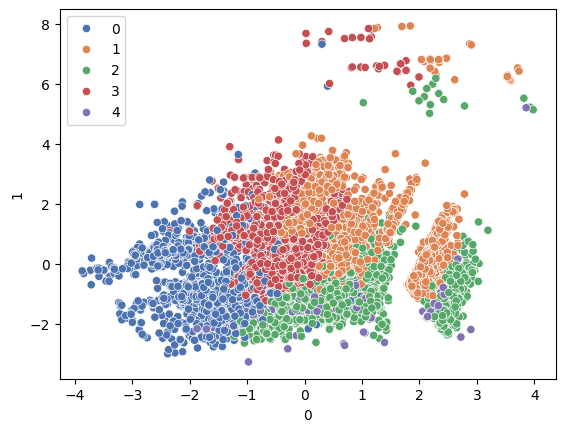

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 6518, ncost: 37564.72613830561
Run: 2, iteration: 2/100, moves: 1428, ncost: 37120.30003111912
Run: 2, iteration: 3/100, moves: 209, ncost: 37107.93451026975
Run: 2, iteration: 4/100, moves: 44, ncost: 37106.949330396186
Run: 2, iteration: 5/100, moves: 5, ncost: 37106.90185743069
Run: 2, iteration: 6/100, moves: 0, ncost: 37106.90185743069
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 2112, ncost: 38205.91791444334
Run: 4, iteration: 2/100, moves: 2156, ncost: 31340.9809912462
Run: 4, iteration: 3/100, moves: 514, ncost: 28252.732439408257
Run: 4, iteration: 4/100, moves: 23, ncost: 28251.623719798845
Run: 4, iteration: 5/100, moves: 4, ncost: 28251.59191234067
Run: 4, iteration: 6/100, moves: 0, ncost: 28251.59191234067
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, 

In [52]:
X2 = X.copy()
X2['reviewsClipped'] = X2.reviews > 365 
X2['priceClipped'] = X2.price > 15 
X2['dateClipped'] = X2.publishedDate.dt.year < 2000

X2.reviews.clip(upper=365, inplace=True)
X2.price.clip(upper=15, inplace=True)
X2.publishedDate.clip(lower=pd.Timestamp('2000-01-01'), inplace=True)

X2.reviews.replace(0, np.nan, inplace=True)
X2.price.replace(0, np.nan, inplace=True)

cluster_visualize(X2.sample(frac=0.10), preprocess=wrap_model(StandardScaler), cluster=KPrototypes(n_clusters=5, n_jobs=8, verbose=1))